## Scenario 2, Simple Web App + Database
### Making the dataset, thats is a load on a pod named "simpleapp".
prerequisites:  

minikube start

https://httpd.apache.org/docs/2.4/programs/ab.html

In [1]:
import time
from otumba.utils import manage_pods
from otumba.utils import get_pod_metrics_scenario_1
from otumba.GeneralPod import Pod

In [2]:
ServerPrometheus = "http://192.168.49.2:30000/"
numberpods = 2
request = 10000
concurrency = 500

In [3]:
filedataset = "dataset_"+str(request)+"_"+str(concurrency)+"_"+str(numberpods)+".csv"
requestpod = "load-generator-jupyter-c"
requestedpod = "simpleapp"

In [4]:
lapso="1m"
namespace="default"

In [5]:
respuesta= get_pod_metrics_scenario_1 (server = ServerPrometheus, lapso = lapso, 
                                       namespace = namespace, podname = requestedpod, 
                                        requestpodname = requestpod)

In [6]:
from datetime import datetime
import csv
respuesta["load"] = '1000'
respuesta["date"] = datetime.now()
header = list(respuesta.keys())
print(respuesta)

{'pods': '2.0', 'file_descriptors': '0.0', 'receive_packets': '0.0', 'transmit_packets': '0.0', 'dropped_packets': '0.0', 'cpu_usage_seconds': '0.0002364228', 'cpu_throttled_seconds': '0.0000000000', 'memory_working_bytes': '0.0', 'memory_usage_bytes': '4.0', 'load': '1000', 'date': datetime.datetime(2021, 9, 2, 20, 42, 37, 701151)}


In [7]:
f = open(filedataset, "w", newline='')
writer = csv.DictWriter(f, fieldnames = header)
writer.writeheader()

In [8]:
manage_pods(numberpods, "pelsan/otumba-scn2:0.0.3", requestedpod, "500m", "200m", "default")

Pod Exist, updating replicas


In [9]:
loadpod = Pod(namepod = requestpod, 
              dockerimage = "httpd", namespace = "default", shell = "/bin/sh")

In [10]:
loadpod.create()

In [11]:
host = "http://simpleapp.default.svc.cluster.local/insert_user"

In [12]:
carga = "ab -n "+str(request)+" -c "+str(concurrency)+" "+host

In [13]:
loadpod.exec_command(carga)
countstdout=0
while loadpod.resp.is_open():
    resp_stdout=""
    resp_stderr=""
    longitud =0
    respuesta = get_pod_metrics_scenario_1 (server = ServerPrometheus, lapso = lapso, 
                                       namespace = namespace, podname = requestedpod, 
                                        requestpodname = requestpod)
    respuesta["load"] = str(concurrency)
    respuesta["date"] = datetime.now()
    writer.writerow(respuesta)
    if loadpod.resp.peek_stdout():
        resp_stdout= loadpod.resp.read_stdout()
        longitud= len(resp_stdout)
        countstdout= countstdout+1
    if loadpod.resp.peek_stderr():
        resp_stderr=loadpod.resp.read_stderr()
        print("STDERR: %s" % resp_stderr)
        inicioerror = resp_stderr.find("Completed")
        if inicioerror == -1:
            failedrequest=resp_stderr
            break
    if  (longitud >300):
        inicio = resp_stdout.find("Failed requests")
        if (inicio > -1):
            fin = resp_stdout.find("Total transferred")
            failedrequest=resp_stdout[inicio+16:fin-1]
        finalresponse = resp_stdout.split("\n")
    if countstdout==2:
        break
    #loadpod.resp.update(timeout=1)
respuesta =  failedrequest.strip()
f.close()

ab -n 10000 -c 500 http://simpleapp.default.svc.cluster.local/insert_user
STDERR: Completed 1000 requests

STDERR: Completed 2000 requests

STDERR: Completed 3000 requests

STDERR: Completed 4000 requests

STDERR: Completed 5000 requests

STDERR: Completed 6000 requests

STDERR: Completed 7000 requests

STDERR: Completed 8000 requests

STDERR: Completed 9000 requests

STDERR: Completed 10000 requests
Finished 10000 requests



In [14]:
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns

dataframe = pd.read_csv(filedataset)
#dataframe = pd.read_csv("dataset_10000_2000_60.cvs")

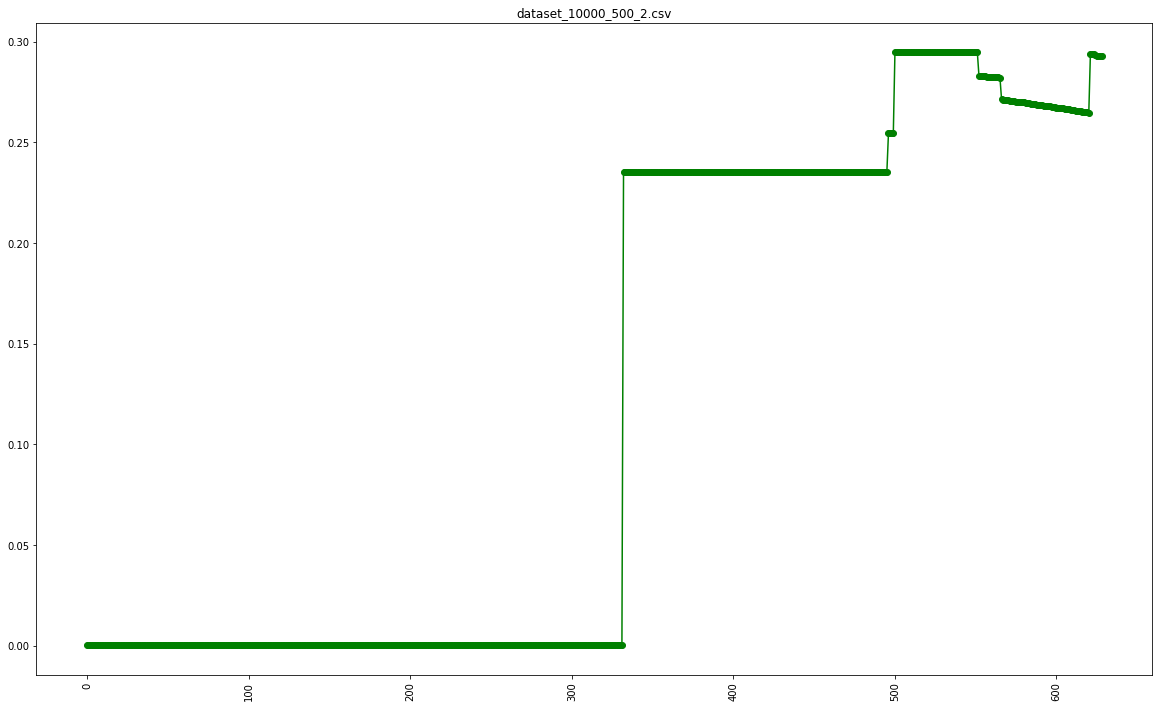

In [15]:
plt.figure(figsize=(20,12))
plt.title(filedataset)
plt.xticks(rotation = 90)
#plt.plot(dataframe.memory_working_bytes, c = "cyan", marker = "o")
plt.plot(dataframe.cpu_usage_seconds, c = "green", marker = "o")
plt.show()